<a href="https://colab.research.google.com/github/medaittouda/Business-Intelligence-BI-/blob/main/Iris_Roi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python-headless numpy


In [2]:
from google.colab import files
uploaded = files.upload()

Saving iRIS.jpg to iRIS.jpg


/tmp/ipython-input-3504562783.py:35: RuntimeWarning: overflow encountered in scalar subtract
  distances = [np.sqrt((c[0]-pupil_x)**2 + (c[1]-pupil_y)**2) for c in iris_circles[0]]


Pupil radius: 79, area: 19606.7
Iris radius: 95, area: 28352.9
Annulus area: 8746.2


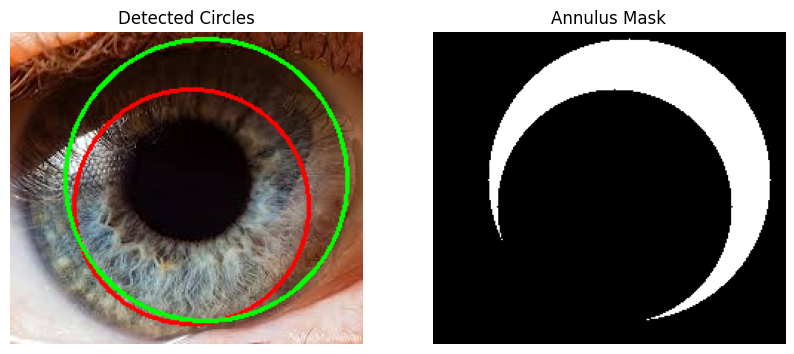

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load uploaded image
image_path = "iRIS.jpg"
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Preprocessing: CLAHE + blur
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_clahe = clahe.apply(gray)
gray_blur = cv2.GaussianBlur(gray_clahe, (5,5), 0)

# Detect pupil (small radius)
pupil_circles = cv2.HoughCircles(
    gray_blur, cv2.HOUGH_GRADIENT, dp=1, minDist=50,
    param1=50, param2=30, minRadius=20, maxRadius=80
)

if pupil_circles is not None:
    pupil_circles = np.uint16(np.around(pupil_circles))
    pupil_x, pupil_y, pupil_r = pupil_circles[0,0]
else:
    pupil_x, pupil_y, pupil_r = gray.shape[1]//2, gray.shape[0]//2, 40  # default center

# Detect iris (larger radius)
iris_circles = cv2.HoughCircles(
    gray_blur, cv2.HOUGH_GRADIENT, dp=1, minDist=50,
    param1=50, param2=30, minRadius=80, maxRadius=150
)

if iris_circles is not None:
    iris_circles = np.uint16(np.around(iris_circles))
    distances = [np.sqrt((c[0]-pupil_x)**2 + (c[1]-pupil_y)**2) for c in iris_circles[0]]
    idx = np.argmin(distances)
    iris_x, iris_y, iris_r = iris_circles[0, idx]
else:
    iris_x, iris_y, iris_r = pupil_x, pupil_y, 120

# Create annulus mask
mask = np.zeros_like(gray, dtype=np.uint8)
cv2.circle(mask, (iris_x, iris_y), iris_r, 255, -1)
cv2.circle(mask, (pupil_x, pupil_y), pupil_r, 0, -1)

# Compute basic geometry
pupil_area = np.pi * pupil_r**2
iris_area = np.pi * iris_r**2
annulus_area = iris_area - pupil_area

print(f"Pupil radius: {pupil_r}, area: {pupil_area:.1f}")
print(f"Iris radius: {iris_r}, area: {iris_area:.1f}")
print(f"Annulus area: {annulus_area:.1f}")

# Visualization using matplotlib
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Detected Circles")
vis = img.copy()
cv2.circle(vis, (pupil_x, pupil_y), pupil_r, (0,0,255),2)
cv2.circle(vis, (iris_x, iris_y), iris_r, (0,255,0),2)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Annulus Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()
